### 数据获取与预处理

SNAP(Stanford Large Network Dataset Collection): https://snap.stanford.edu/data/amazon-meta.html

下载数据，将txt文件转为csv文件

In [42]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

with open('amazon-meta.txt') as f:
    data = f.readlines()
data = [x.strip() for x in data]

target_file = open('amazon_preprocessed.txt', 'w', encoding = 'utf-8')
all_row = ['Id', 'title', 'group', 'salesrank', 'categories', 'totalreviews', 'avgrating']

for line in data:
    lines = line.split(':')
    if lines[0] == 'Id':
        if len(all_row) == 7:
            for comp in all_row[:6]:
                target_file.write(comp)
                target_file.write(',')

            target_file.write(all_row[6])
            target_file.write('\n')
            all_row = []
            all_row.append(lines[1].strip())
    if lines[0] == 'title':
        title = ':'.join(lines[1:]).strip().replace(',', ' ').replace('\n', ' ').strip()
        all_row.append(title)
    if lines[0] == 'group' or lines[0] == 'salesrank' or lines[0] == 'categories':
        all_row.append(lines[1].strip())
    elif lines[0] == 'reviews' and lines[1].strip() == 'total':
        all_row.append(lines[2].split(' ')[1])
        all_row.append(lines[4].strip())

target_file.close()

meta = pd.read_csv('amazon_preprocessed.txt', sep = ',')
meta['Id'].iloc[0] = 1
meta.to_csv('amazon_meta.csv', index = False)
    

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9508\1077412725.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['Id'].iloc[0] = 1


读取数据，打印数据前十列，观察数据形式，便于后续分析

In [43]:
df = pd.read_csv('amazon_meta.csv')
print(df.head(10))

   Id                                              title  group  salesrank  \
0   1            Patterns of Preaching: A Sermon Sampler   Book     396585   
1   2                         Candlemas: Feast of Flames   Book     168596   
2   3   World War II Allied Fighter Planes Trading Cards   Book    1270652   
3   4  Life Application Bible Commentary: 1 and 2 Tim...   Book     631289   
4   5    Prayers That Avail Much for Business: Executive   Book     455160   
5   6  How the Other Half Lives: Studies Among the Te...   Book     188784   
6   7                                              Batik  Music       5392   
7   8                                Losing Matt Shepard   Book     277409   
8   9  Making Bread: The Taste of Traditional Home-Ba...   Book     949166   
9  10                             The Edward Said Reader   Book     220379   

   categories  totalreviews  avgrating  
0           2             2        5.0  
1           2            12        4.5  
2           1     

检查缺失值并删除重复值,五值分析

In [44]:
print(df.isnull().any())

df_nodup = df.drop_duplicates()

numeric = ['salesrank', 'categories', 'totalreviews', 'avgrating']
print(df[numeric].describe().loc[['max', '75%', '50%', '25%', 'min']])

Id              False
title           False
group           False
salesrank       False
categories      False
totalreviews    False
avgrating       False
dtype: bool
     salesrank  categories  totalreviews  avgrating
max  3798351.0       116.0        5545.0        5.0
75%   672069.5         6.0           8.0        5.0
50%   300493.0         4.0           2.0        4.0
25%    90744.0         2.0           0.0        0.0
min       -1.0         0.0           0.0        0.0


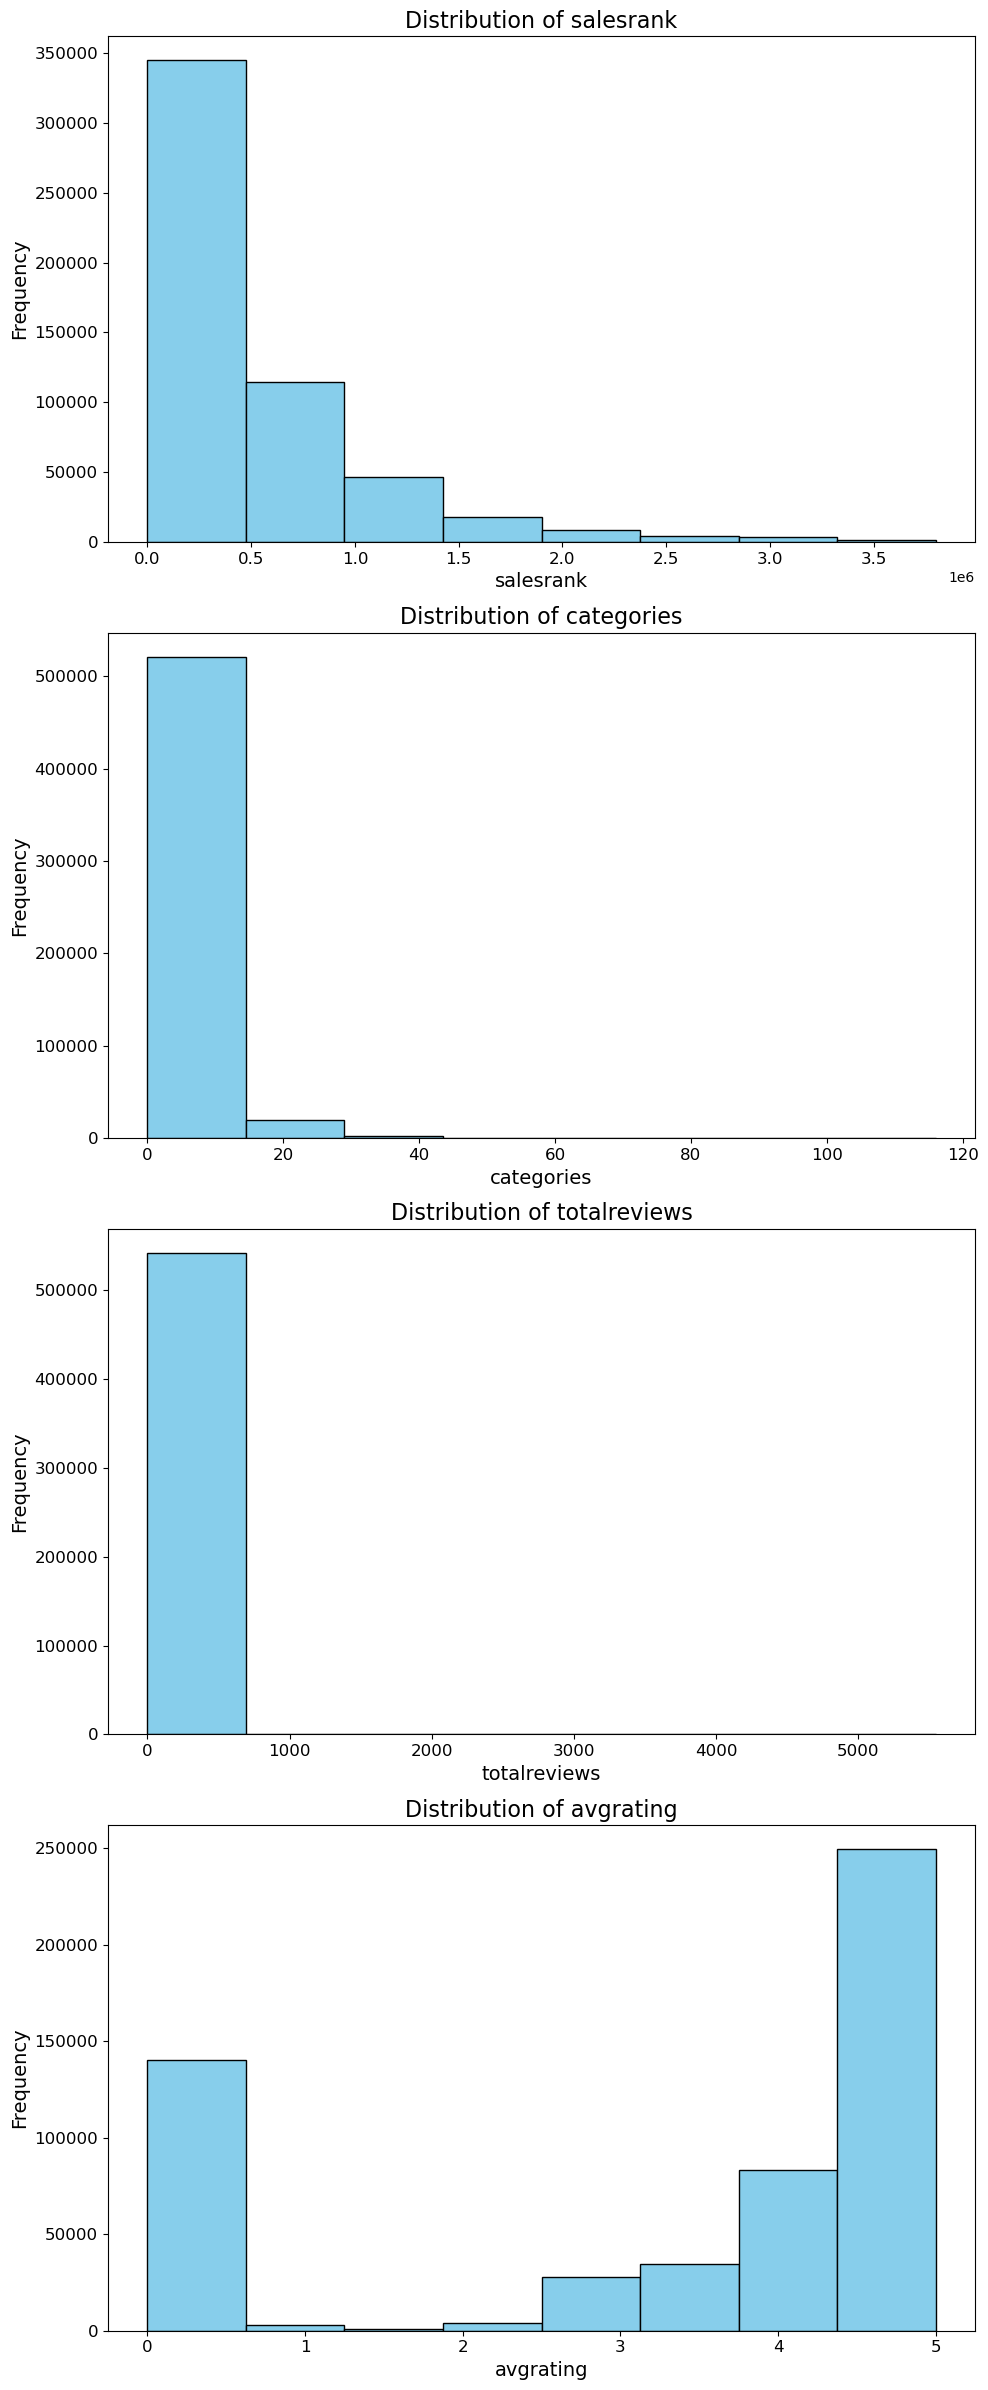

In [45]:
def hist_plot(data, features):
    num_plots = len(features)
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 6*num_plots))
    
    for i, col in enumerate(features):
        ax = axes[i]
        ax.hist(data[col], bins=8, histtype='bar', color='skyblue', edgecolor='black')  # 添加黑色边框
        ax.set_title(f'Distribution of {col}', fontsize=16)
        ax.set_xlabel(col, fontsize=14)
        ax.set_ylabel('Frequency', fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        
    plt.tight_layout()
    plt.show()

hist_plot(df, numeric)


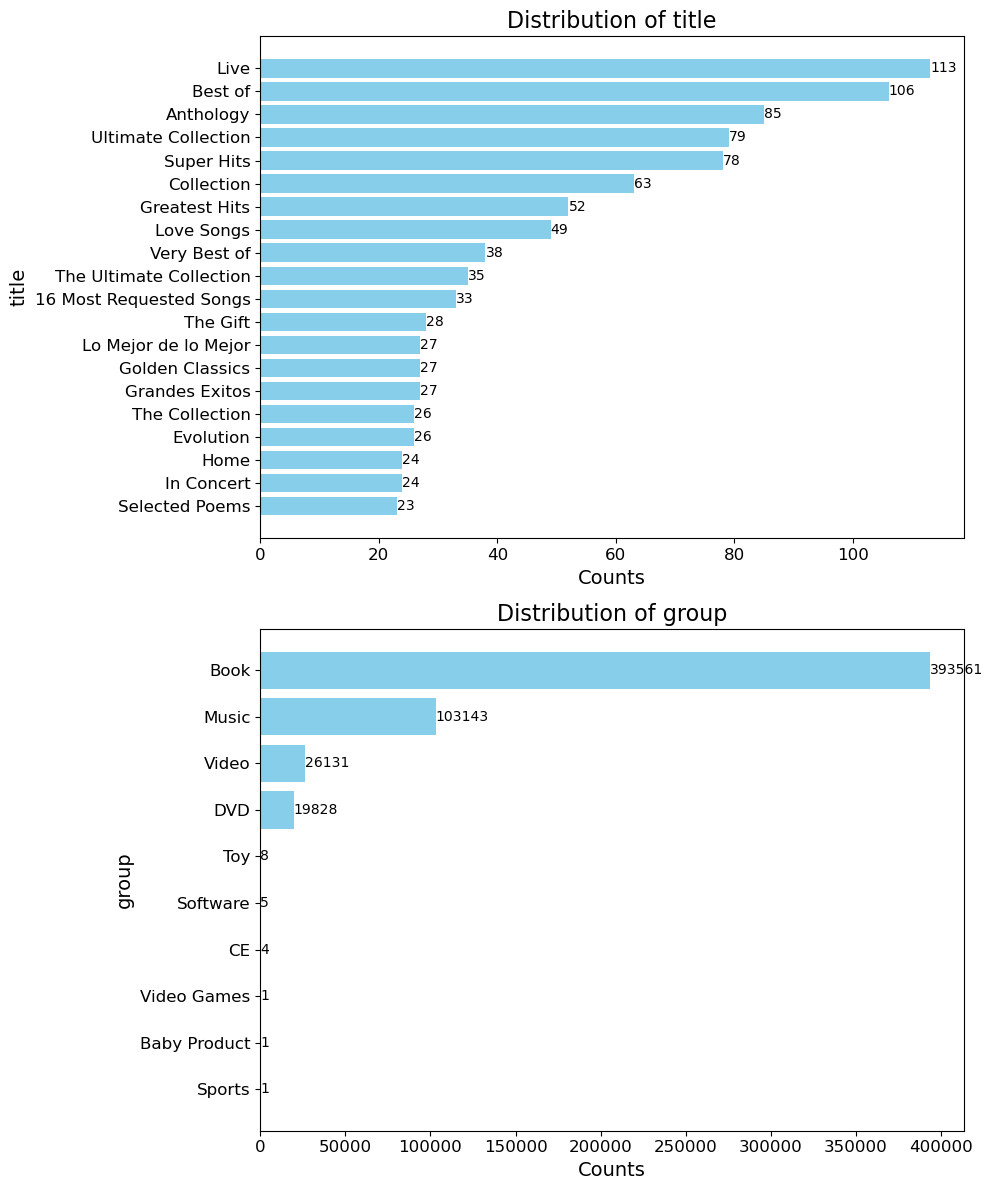

In [46]:
def bar_plot(data, features):
    num_plots = len(features)
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, 6*num_plots))

    for i, col in enumerate(features):
        ax = axes[i]
        counts = data[col].value_counts().head(20)
        bars = ax.barh(counts.index, counts.values, color='skyblue')
        ax.set_title(f'Distribution of {col}', fontsize=16)
        ax.set_xlabel('Counts', fontsize=14)
        ax.set_ylabel(col, fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        ax.invert_yaxis()  # 反转y轴，让最高的条形显示在顶部

        # 在每个柱形上标注数字
        for bar, count in zip(bars, counts.values):
            ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, count, 
                    va='center', ha='left', fontsize=10, color='black')

    plt.tight_layout()
    plt.show()

bar_plot(df, ['title', 'group'])


将数值型属性根据数值划分范围，能更方便的挖掘关联规则

In [47]:
def trans_avg(row):
    if 0 <= row['avgrating'] < 1:
        new = '[0,1)'
    elif 1 <= row['avgrating'] < 2:
        new = '[1,2)'
    elif 2 <= row['avgrating'] < 3:
        new = '[2,3)'
    elif 3 <= row['avgrating'] < 4:
        new = '[3,4)'
    elif 4 <= row['avgrating']:
        new = '[4,5]'
    return new

def trans_reviews(row):
    if 0 <= row['totalreviews'] < 5:
        new = '[0,5)'
    elif 5 <= row['totalreviews'] < 10:
        new = '[5,10)'
    elif 10 <= row['totalreviews'] < 1000:
        new = '[10,1000)'
    elif 1000 <= row['totalreviews'] < 3000:
        new = '[1000,3000)'
    elif 3000 <= row['totalreviews']:
        new = '[3000,-)'
    return new

def trans_categories(row):
    if 0 <= row['categories'] < 2:
        new = '[0,2)'
    elif 2 <= row['categories'] < 5:
        new = '[2,5)'
    elif 5 <= row['categories'] < 10:
        new = '[5,10)'
    elif 10 <= row['categories'] < 50:
        new = '[10,50)'
    elif 50 <= row['categories']:
        new = '[50,-)'
    return new

def trans_salesrank(row):
    if row['salesrank'] < 500000:
        new = '[-,500000)'
    elif 500000 <= row['salesrank'] < 1000000:
        new = '[500000,1000000)'
    elif 1000000 <= row['salesrank'] < 1500000:
        new = '[1000000,1500000)'
    elif 1500000 <= row['salesrank'] < 2000000:
        new = '[1500000,2000000)'
    elif 2000000 <= row['salesrank']:
        new = '[2000000,-)'
    return new

In [48]:
new_rating = []
new_reviews = []
new_rank = []
new_cat = []
for i, row in df.iterrows():
    new_rating.append(trans_avg(row))
    new_reviews.append(trans_reviews(row))
    new_rank.append(trans_salesrank(row))
    new_cat.append(trans_categories(row))
df['avgrating'] = new_rating
df['totalreviews'] = new_reviews
df['categories'] = new_cat
df['salesrank'] = new_rank
df.head(5)

,Id,title,group,salesrank,categories,totalreviews,avgrating
0,1,Patterns of Preaching: A Sermon Sampler,Book,"[-,500000)","[2,5)","[0,5)","[4,5]"
1,2,Candlemas: Feast of Flames,Book,"[-,500000)","[2,5)","[10,1000)","[4,5]"
2,3,World War II Allied Fighter Planes Trading Cards,Book,"[1000000,1500000)","[0,2)","[0,5)","[4,5]"
3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,"[500000,1000000)","[5,10)","[0,5)","[4,5]"
4,5,Prayers That Avail Much for Business: Executive,Book,"[-,500000)","[2,5)","[0,5)","[0,1)"


将group、salesrank、categories、totalreviews和avgrating提取出来，转化为list

In [49]:
data = df[['avgrating', 'totalreviews', 'categories', 'salesrank', 'group']]
print(data.head(5))
arr = np.array(data)
d = arr.tolist()

  avgrating totalreviews categories          salesrank group
0     [4,5]        [0,5)      [2,5)         [-,500000)  Book
1     [4,5]    [10,1000)      [2,5)         [-,500000)  Book
2     [4,5]        [0,5)      [0,2)  [1000000,1500000)  Book
3     [4,5]        [0,5)     [5,10)   [500000,1000000)  Book
4     [0,1)        [0,5)      [2,5)         [-,500000)  Book


### 频繁模式挖掘

利用apyori挖掘数据集中的频繁项集和关联规则，设置最小支持度为0.1

In [53]:
from apyori import apriori
result = list(apriori(transactions = d, min_support = 0.1, min_confidence = 0.5))

def show_result(result):
    lastitems = []
    for i in result:
        tempitem = ':'.join(i.items)
        sup = round(i.support, 4)
        for j in i.ordered_statistics:
            col = []
            tempitembase = ':'.join(j.items_base)
            tempitemadd = ':'.join(j.items_add)
            col.append(tempitem)
            col.append(sup)
            col.append(tempitembase)
            col.append(tempitemadd)
            col.append(round(j.confidence, 4))
            col.append(round(j.lift, 2))
            lastitems.append(col)
    lastitems = pd.DataFrame(lastitems)
    lastitems.columns = ['LastItem', 'Support', 'ItemBase', 'ItemAdd', 'Confidence', 'Lift']
    lastitems.index = range(len(lastitems))
    print(len(lastitems))
    lastitems = lastitems.sort_values('Confidence', ascending = False).reset_index()
    print(lastitems.head(10))

    return lastitems

lastitems = show_result(result)

128
   index                     LastItem  Support                ItemBase  \
0     54             [0,1):[0,5):Book   0.2125              [0,1):Book   
1    101            [0,1):[2,5):[0,5)   0.1197             [0,1):[2,5)   
2     28                  [0,1):[0,5)   0.2579                   [0,1)   
3     86       [0,1):[0,5):[-,500000)   0.1005        [0,1):[-,500000)   
4    119       [0,1):[0,5):[2,5):Book   0.1037        [0,1):[2,5):Book   
5     85       Music:[4,5]:[-,500000)   0.1375             Music:[4,5]   
6     79  [500000,1000000):[4,5]:Book   0.1086  [500000,1000000):[4,5]   
7     74  [500000,1000000):[2,5):Book   0.1131  [500000,1000000):[2,5)   
8     17        [500000,1000000):Book   0.2020        [500000,1000000)   
9     18             Music:[-,500000)   0.1845                   Music   

      ItemAdd  Confidence  Lift  
0       [0,5)      1.0000  1.55  
1       [0,5)      1.0000  1.55  
2       [0,5)      1.0000  1.55  
3       [0,5)      1.0000  1.55  
4       [0,

### 模式命名与分析

分析：以index为18的数据为例，存在“Music->[-,500000)”，即“音乐类别的产品->销售排名高于500000”，可以得出，音乐类别的产品的销售排名约有97%的概率高于500000，且这种情况的发生比例约为18.35%，其余数据同理可进行解释。

##### 模式命名：音乐产品销售模式

### 可视化

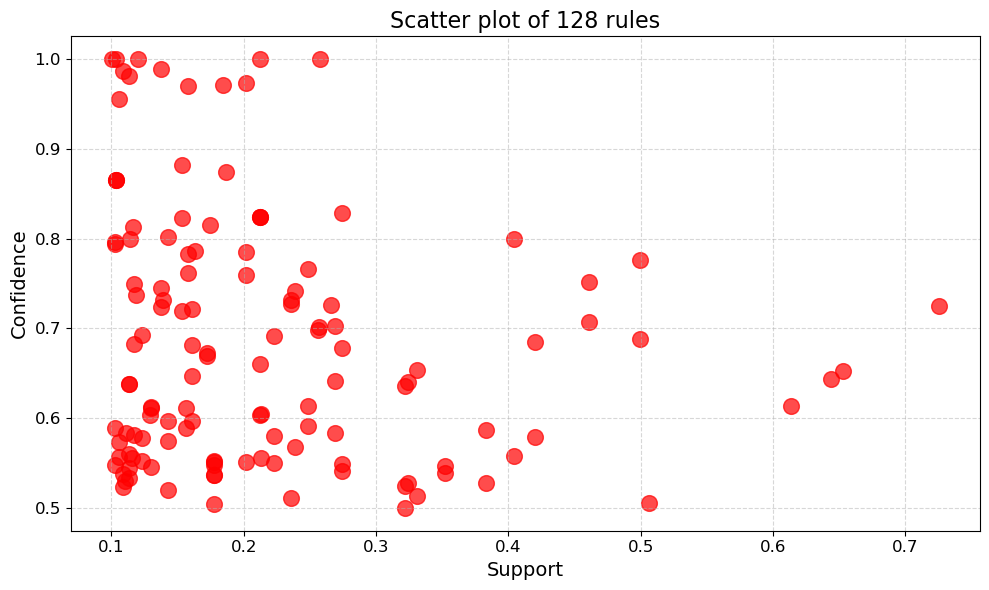

In [59]:
def scatter(items, size):
    plt.figure(figsize=(10, 6))
    plt.scatter(items['Support'], items['Confidence'], c='r', s=size, alpha=0.7)  # 设置透明度为0.7
    plt.grid(True, linestyle='--', alpha=0.5)  # 设置虚线网格，透明度为0.5
    plt.xlabel('Support', fontsize=14)
    plt.ylabel('Confidence', fontsize=14)
    plt.title(f'Scatter plot of {size} rules', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    plt.show()

scatter(lastitems, 128)


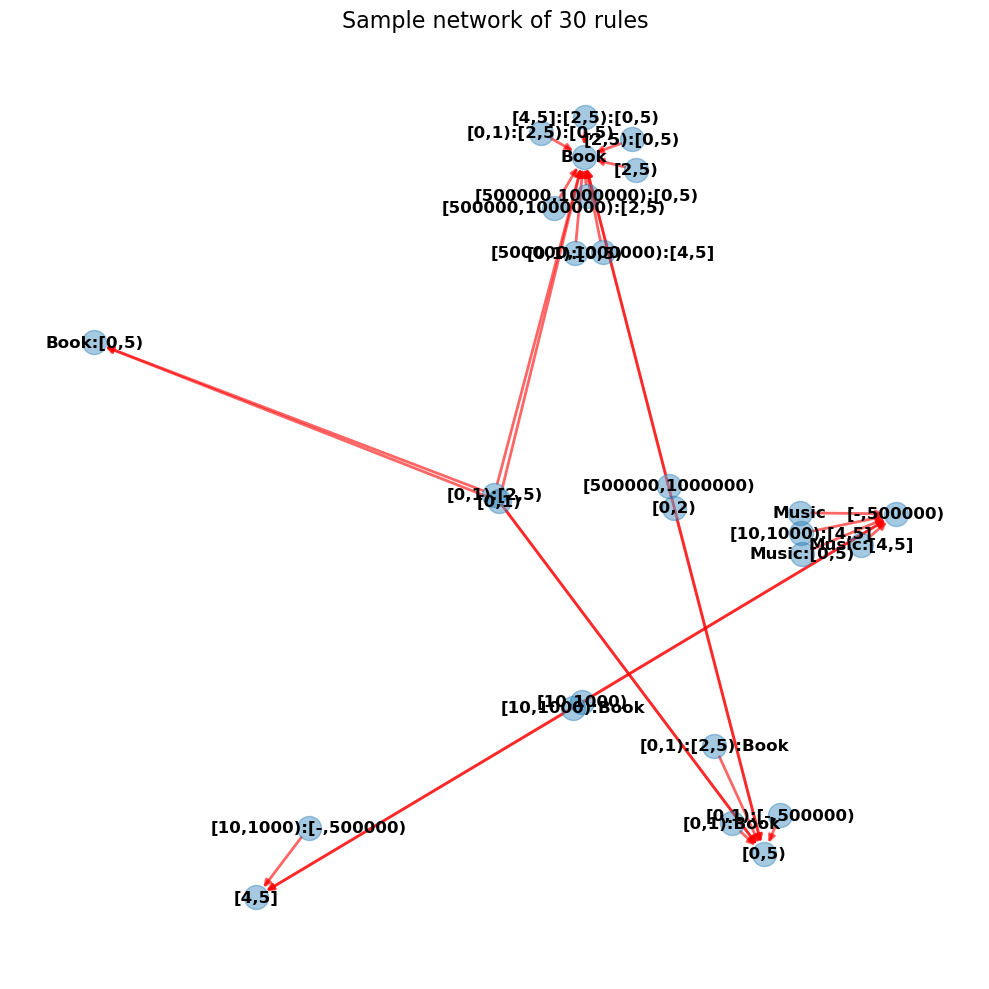

In [61]:
import networkx as nx

def network(items, size):
    plt.figure(figsize=(10, 10))
    # 生成社交网络图
    G = nx.DiGraph()

    draw_df = items.head(size)

    # 为图像添加边
    for idx, row in draw_df.iterrows():
        G.add_edge(row['ItemBase'], row['ItemAdd'], weight=row['Confidence'])

    # 定义不同权重的边
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.6]
    emidle = [(u, v) for (u, v, d) in G.edges(data=True) if 0.45 <= d['weight'] <= 0.6]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < 0.45]

    # 图的布局方式
    pos = nx.spring_layout(G)

    # 根据规则的置信度节点的大小
    nx.draw_networkx_nodes(G, pos, node_size=300, alpha=0.4)

    # 设置边的形式
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=2, alpha=0.6, edge_color='r', style='solid')
    nx.draw_networkx_edges(G, pos, edgelist=emidle, width=2, alpha=0.6, edge_color='g', style='dashdot')
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=2, alpha=0.6, edge_color='b', style='dashed')

    # 为节点添加标签
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    plt.axis('off')
    plt.title(f'Sample network of {size} rules', fontsize=16)
    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    plt.show()

network(lastitems, 30)
